# Perturb-seq K562 co-expression

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [2]:
pd.set_option('max_columns', None)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/k562/'

### Read the guide labled K562 data

From perturbseq paper

In [9]:
adata = sc.read(data_path + 'h5ad/filtered-cellcycle.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
guides = adata.obs.guides.drop_duplicates().tolist()
guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

In [17]:
adata.X = adata.X.tocsr()

### Setup memento

In [18]:
adata.obs['q'] = 0.07

In [19]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:68: RankWarning: Polyfit may be poorly conditioned
  all_res_var = estimator._residual_variance(all_m, all_v, estimator._fit_mv_regressor(all_m, all_v))


### Get moments from all groups

In [20]:
adata_moments = adata.copy().copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [21]:
memento.create_groups(adata_moments, label_columns=['phase'])
memento.compute_1d_moments(adata_moments, min_perc_group=.9)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [22]:
moment_df = memento.get_1d_moments(adata_moments)
moment_df = moment_df[0].merge(moment_df[1], on='gene', suffixes=('_m', '_v'))

In [23]:
moment_df = moment_df[['gene','sg^G1_m', 'sg^S_m', 'sg^G2M_m', 'sg^G1_v', 'sg^S_v', 'sg^G2M_v']]

### Cell cycle 1D moments

In [24]:
adata.obs['s_phase'] = (adata.obs.phase == 'S').astype(int)
adata.obs['g1_phase'] = (adata.obs.phase == 'G1').astype(int)
adata.obs['g2m_phase'] = (adata.obs.phase == 'G2M').astype(int)

In [57]:
g1_s = adata[adata.obs.phase.isin(['S', 'G1'])].copy().copy()
s_g2 = adata[adata.obs.phase.isin(['S', 'G2M'])].copy().copy()
g2_g1 = adata[adata.obs.phase.isin(['G1', 'G2M'])].copy().copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [58]:
memento.create_groups(g1_s, label_columns=['s_phase', 'leiden'])
memento.compute_1d_moments(g1_s, min_perc_group=.9)

memento.create_groups(s_g2, label_columns=['g2m_phase', 'leiden'])
memento.compute_1d_moments(s_g2, min_perc_group=.9)

memento.create_groups(g2_g1, label_columns=['g1_phase', 'leiden'])
memento.compute_1d_moments(g2_g1, min_perc_group=.9)

In [59]:
memento.ht_1d_moments(
    g1_s, 
    formula_like='1 + s_phase',
    cov_column='s_phase', 
    num_boot=20000, 
    verbose=1,
    num_cpus=70)

memento.ht_1d_moments(
    s_g2, 
    formula_like='1 + g2m_phase',
    cov_column='g2m_phase', 
    num_boot=20000, 
    verbose=1,
    num_cpus=70)

memento.ht_1d_moments(
    g2_g1, 
    formula_like='1 + g1_phase',
    cov_column='g1_phase', 
    num_boot=20000, 
    verbose=1,
    num_cpus=70)

g1_s.write(data_path + 'cell_cycle/g1_s.h5ad')
s_g2.write(data_path + 'cell_cycle/s_g2.h5ad')
g2_g1.write(data_path + 'cell_cycle/g2_g1.h5ad')

[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    6.1s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:   12.0s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:   19.4s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   28.3s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   39.3s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   51.7s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:  1.1min
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:  1.4min
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:  1.8min
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:  2.1min
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  2.5min
[Parallel(n_jobs=70)]: Done 8310 tasks      | elapsed:  3.0min
[Parallel(n_jobs=70)]: Done 8481 out of 8481 | elapsed:  3.2min finished
[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)

In [60]:
def get_1d_dfs(subset):

    df = memento.get_1d_ht_result(subset)
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    
    return df

In [61]:
g1_s_1d = get_1d_dfs(g1_s)
s_g2_1d = get_1d_dfs(s_g2)
g2_g1_1d = get_1d_dfs(g2_g1)

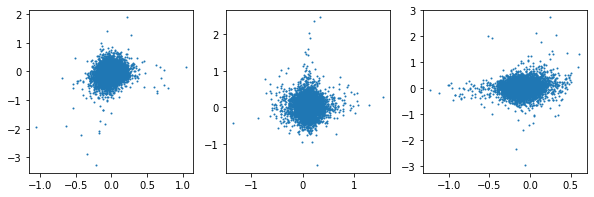

In [62]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.scatter(g1_s_1d['de_coef'], g1_s_1d['dv_coef'], s=1)
plt.subplot(1,3,2)
plt.scatter(s_g2_1d['de_coef'], s_g2_1d['dv_coef'], s=1)
plt.subplot(1,3,3)
plt.scatter(g2_g1_1d['de_coef'], g2_g1_1d['dv_coef'], s=1)

In [63]:
sig_genes = set(
    g1_s_1d.query('dv_fdr < 0.01 & (dv_coef < -1 | dv_coef > 1)').gene.tolist() +\
    s_g2_1d.query('dv_fdr < 0.01 & (dv_coef < -1 | dv_coef > 1)').gene.tolist() + \
    g2_g1_1d.query('dv_fdr < 0.01 & (dv_coef < -1 | dv_coef > 1)').gene.tolist())

### GSEA + scatterplots

In [130]:
def plot_scatters(gene_set, name, c='k'):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.scatter(g1_s_1d['de_coef'], g1_s_1d['dv_coef'], s=1, color='gray')
    plt.scatter(g1_s_1d.query('gene in @gene_set')['de_coef'], g1_s_1d.query('gene in @gene_set')['dv_coef'], s=15, color=c)
    plt.xlabel('G1->S')
#     plt.xlim(-1.2,1.2); plt.ylim(-1.2,1.2);

    plt.subplot(1,3,2)
    plt.scatter(s_g2_1d['de_coef'], s_g2_1d['dv_coef'], s=1, color='gray')
    plt.scatter(s_g2_1d.query('gene in @gene_set')['de_coef'], s_g2_1d.query('gene in @gene_set')['dv_coef'], s=15, color=c)
    plt.title(name)
    plt.xlabel('S->G2M')
#     plt.xlim(-1.2,1.2); plt.ylim(-1.2,1.2);

    plt.subplot(1,3,3)
    plt.scatter(g2_g1_1d['de_coef'], g2_g1_1d['dv_coef'], s=1, color='gray')
    plt.scatter(g2_g1_1d.query('gene in @gene_set')['de_coef'], g2_g1_1d.query('gene in @gene_set')['dv_coef'], s=15, color=c)
    plt.xlabel('G2M->G1')
#     plt.xlim(-1.2,1.2); plt.ylim(-1.2,1.2);


In [131]:
import gseapy as gp
from gseapy.plot import gseaplot


In [133]:
pre_res = gp.prerank(
    rnk=s_g2_1d.query('de_coef > 0 & de_fdr < 0.01')[['gene','dv_coef']].sort_values('dv_coef'), 
    gene_sets='GO_Biological_Process_2018',
    processes=4,
    permutation_num=100, # reduce number to speed up testing
    outdir=None, seed=6)

In [134]:
terms = pre_res.res2d.index


In [135]:
gsea_table = pre_res.res2d.sort_index().sort_values('fdr')


In [136]:
gsea_table.head(5)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
regulation of cyclin-dependent protein serine/threonine kinase activity (GO:0000079),0.673582,2.143093,0.0,0.000000,68,31,SERTAD1;CDKN2C;CCNL1;CDKN1B;CCND1;PSRC1;CDKN3;...,SERTAD1;CDKN2C;CCNL1;CDKN1B;CCND1;PSRC1;CDKN3;...
negative regulation of G2/M transition of mitotic cell cycle (GO:0010972),0.674013,2.058674,0.0,0.016581,63,23,PSMD12;UBC;AURKA;PSMD11;PSMC5;PINX1;PSMC3;PSMD...,PSMD12;UBC;AURKA;PSMD11;PSMC5;PINX1;PSMC3;PSMD...
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),0.534369,2.031044,0.0,0.027635,90,80,RPL39;RPL23;RPS24;SRP14;RPL38;RPS29;RPS25;RPL4...,RPL39;RPL23;RPS24;SRP14;RPL38;RPS29;RPS25;RPL4...
cotranslational protein targeting to membrane (GO:0006613),0.548084,1.995741,0.0,0.029477,94,82,ARL6IP1;RPL39;RPL23;RPS24;SRP14;RPL38;RPS29;RP...,ARL6IP1;RPL39;RPL23;RPS24;SRP14;RPL38;RPS29;RP...
protein targeting to ER (GO:0045047),0.534121,1.997935,0.0,0.035373,98,81,RPL39;RPL23;RPS24;SRP14;RPL38;RPS29;RPS25;RPL4...,RPL39;RPL23;RPS24;SRP14;RPL38;RPS29;RPS25;RPL4...


In [137]:
terms = gsea_table.index


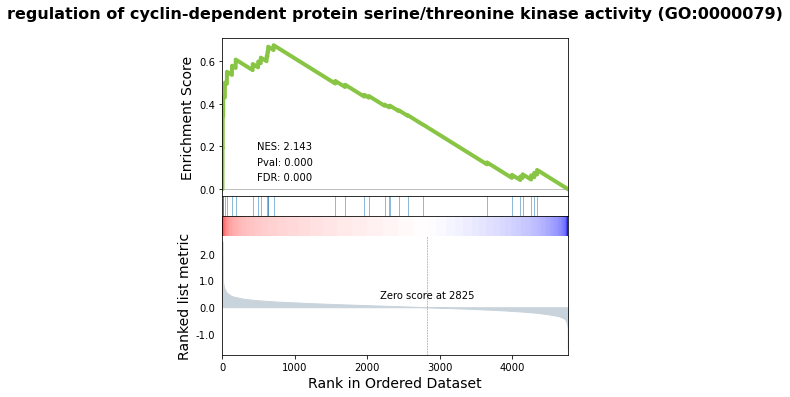

In [139]:
idx=0
gseaplot(rank_metric=pre_res.ranking, term=terms[idx], **pre_res.results[terms[idx]])


In [126]:
gsea_table = pre_res.res2d.sort_index().sort_values('fdr')


In [144]:
stress_genes

['SERTAD1',
 'CDKN2C',
 'CCNL1',
 'CDKN1B',
 'CCND1',
 'PSRC1',
 'CDKN3',
 'GTF2H1',
 'CKS2',
 'CDK7',
 'CCNK',
 'CDK5RAP3',
 'CKS1B',
 'CDC25C']

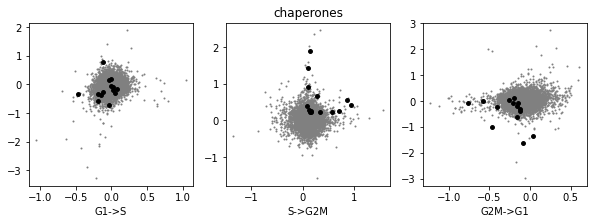

In [142]:
stress_genes = gsea_table['ledge_genes'].iloc[0].split(';')
plot_scatters(stress_genes, 'chaperones')

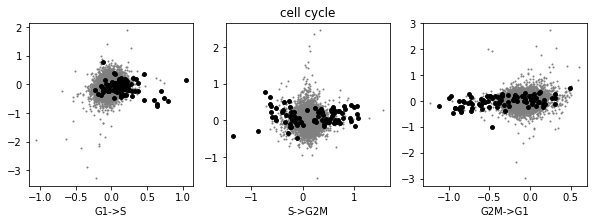

In [143]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]
plot_scatters(cell_cycle_genes, 'cell cycle')

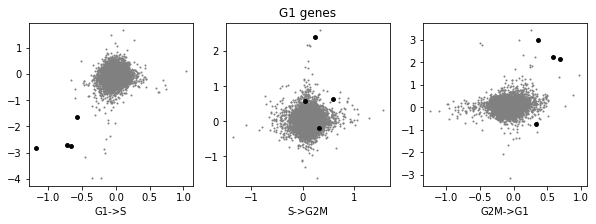

In [55]:
manual_gene_set = g1_s_1d.query('dv_coef < -1 & de_coef < -0.5').gene.tolist()
plot_scatters(manual_gene_set, 'G1 genes')

In [56]:
manual_gene_set

['G0S2', 'ID2', 'LYZ', 'LINC00659']

### Get any hits for KOs

In [145]:
guides = adata.obs.guides.drop_duplicates().tolist()
guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

### Get moments for the gene classes

In [147]:
for g in ko_genes:
    
    print(g)
    
    subset = adata[adata.obs.WT | (adata.obs.KO_GENE == g)].copy().copy()
    
    memento.create_groups(subset, label_columns=['KO', 'leiden'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    target_genes = list(set(subset.var.index)-set(ko_genes))
#     memento.compute_2d_moments(subset, gene_pairs=list(itertools.product([g], target_genes)))
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + KO',
        cov_column='KO', 
        num_boot=10000, 
        verbose=1,
        num_cpus=70)
    
#     subset.write(data_path + '2d_self_h5ad/{}.h5ad'.format(g))
    
    break

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PTGER2


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    5.4s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    8.1s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:   11.3s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   15.2s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   20.0s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   25.8s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   33.0s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   40.6s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:   49.0s
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:   58.6s
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.1min
[Parallel(n_jobs=70)]: Done 8310 tasks      | elapsed:  1.3min
[Parallel(n_jobs=70)]: Done 8449 out of 8449 | elapsed:  1.4min finished


In [149]:
df = memento.get_1d_ht_result(subset)
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])

In [151]:
df.query('de_fdr < 0.1')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr


(array([807., 867., 858., 922., 899., 860., 775., 817., 801., 843.]),
 array([3.92320373e-04, 1.00353088e-01, 2.00313856e-01, 3.00274624e-01,
        4.00235392e-01, 5.00196160e-01, 6.00156928e-01, 7.00117696e-01,
        8.00078464e-01, 9.00039232e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

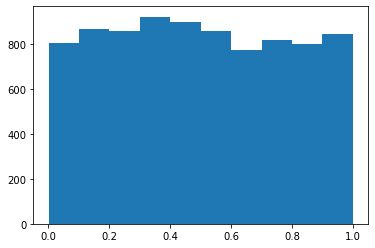

In [155]:
plt.hist(df['dv_pval'])

Text(0.5, 1.0, 'Variability')

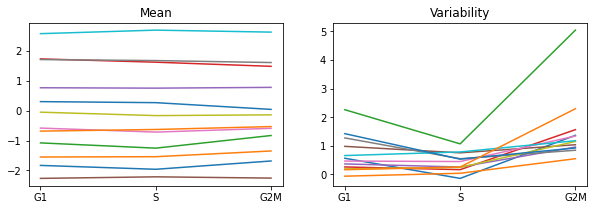

In [250]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(moment_df.query('gene in @stress_genes').iloc[:, 1:4].values.T)
plt.xticks([0,1,2],['G1', 'S', 'G2M'])
plt.title('Mean')

plt.subplot(1, 2, 2)
plt.plot(moment_df.query('gene in @stress_genes').iloc[:, 4:].values.T)
plt.xticks([0,1,2],['G1', 'S', 'G2M'])
plt.title('Variability')

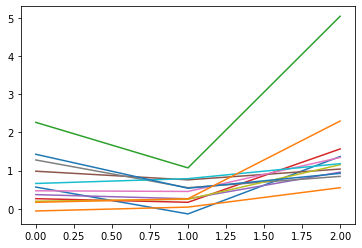

In [241]:
plt.plot(moment_df.query('gene in @stress_genes').iloc[:, 4:].values.T)

In [ ]:
df['dv_pval'].hist(bins=50)

### Find self-DC genes

In [ ]:
for g in ko_genes:
    
    subset = adata[adata.obs.WT | (adata.obs.KO_GENE == g)].copy().copy()
    
    memento.create_groups(subset, label_columns=['KO'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    if g not in subset.var.index:
        continue
    
    target_genes = list(set(subset.var.index)-set(ko_genes))
#     memento.compute_2d_moments(subset, gene_pairs=list(itertools.product([g], target_genes)))
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + KO',
        cov_column='KO', 
        num_boot=10000, 
        verbose=1,
        num_cpus=70)
    
#     subset.write(data_path + '2d_self_h5ad/{}.h5ad'.format(g))
    
    break

In [ ]:
df = memento.get_1d_ht_result(subset)

In [ ]:
df = memento.get_1d_ht_result(subset)

In [ ]:
df['de_pval'].hist(bins=50)

In [ ]:
for g, result in result_1d_dict.items():
    
    result.to_csv(data_path + '/result_1d/{}.csv'.format(g), index=False)

### Get 1D results

In [ ]:
result_1d_dict = {g:pd.read_csv(data_path + '/result_1d/{}.csv'.format(g)) for g in guides if ('INTER' not in g and 'nan' not in g)}

In [ ]:
g = 'p_sgGABPA_9'
df = result_1d_dict[g]
df.query('de_fdr < 0.1 | dv_fdr < 0.1')

In [ ]:
for g in guides:
    
    df = result_1d_dict[g]
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    
    print(g, df.query('de_fdr < 0.15').shape[0], df.query('dv_fdr < 0.15').shape[0])

### DV shift plots

In [ ]:
for g in guides:
    df = result_1d_dict[g]
    plt.figure()
    sns.kdeplot(df['dv_coef']);
    plt.plot([0, 0], [0, 2])
    plt.title(g)
    plt.xlim(-2, 2)
    

### within WT

In [ ]:
adata[adata.obs.WT].obs.guides.value_counts()

In [ ]:
subset = adata[(adata.obs.guides=='p_INTERGENIC393453') | (adata.obs.guides=='p_INTERGENIC216151') ].copy().copy()

memento.create_groups(subset, label_columns=['guides'])
memento.compute_1d_moments(subset, min_perc_group=.9)

memento.ht_1d_moments(
    subset, 
    formula_like='1 + guides',
    cov_column='guides', 
    num_boot=10000, 
    verbose=1,
    num_cpus=14)

wt_result = memento.get_1d_ht_result(subset)

In [ ]:
sns.kdeplot(wt_result.dv_coef)
plt.title('WT')
plt.plot([0, 0], [0, 2])

### Get the change in magnitude for each guide

In [ ]:
coef_mag = []
for g, df in result_1d_dict.items():
    coef_mag.append((g, df['de_coef'].abs().median()))
coef_mag = pd.DataFrame(coef_mag, columns=['guide', 'de_mag'])
coef_mag['gene'] = coef_mag['guide'].str.split('_').str[1].str[2:]

### Get WT variability of each TF

In [ ]:
wt_adata = adata[adata.obs['WT']].copy().copy()

In [ ]:
tfs = adata.obs.query('KO==1').KO_GENE.drop_duplicates().tolist()

In [ ]:
memento.create_groups(wt_adata, label_columns=['KO'])
memento.compute_1d_moments(wt_adata, min_perc_group=.9,)

In [ ]:
tf_moments = memento.get_1d_moments(wt_adata, groupby='KO')

### Compare WT variability to De mag

In [ ]:
merged = coef_mag.merge(tf_moments[1], on='gene')

In [ ]:
stats.spearmanr(merged['de_mag'], merged['KO_0'])

In [ ]:
plt.scatter(merged['de_mag'], merged['KO_0'])

### Number of TF binding sites within 5k(?) KB


In [ ]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [ ]:
encode_links = {
    'ELK1':'https://www.encodeproject.org/files/ENCFF119SCQ/@@download/ENCFF119SCQ.bed.gz',
    'ELF1':'https://www.encodeproject.org/files/ENCFF133TSU/@@download/ENCFF133TSU.bed.gz',
    'IRF1':'https://www.encodeproject.org/files/ENCFF203LRV/@@download/ENCFF203LRV.bed.gz',
    'ETS1':'https://www.encodeproject.org/files/ENCFF461PRP/@@download/ENCFF461PRP.bed.gz',
    'EGR1':'https://www.encodeproject.org/files/ENCFF375RDB/@@download/ENCFF375RDB.bed.gz',
    'YY1':'https://www.encodeproject.org/files/ENCFF635XCI/@@download/ENCFF635XCI.bed.gz',
    'GABPA':'https://www.encodeproject.org/files/ENCFF173GUD/@@download/ENCFF173GUD.bed.gz',
    'E2F4':'https://www.encodeproject.org/files/ENCFF225TLP/@@download/ENCFF225TLP.bed.gz',
    'NR2C2':'https://www.encodeproject.org/files/ENCFF263VIC/@@download/ENCFF263VIC.bed.gz',
    'CREB1':'https://www.encodeproject.org/files/ENCFF193LLN/@@download/ENCFF193LLN.bed.gz'
}

In [ ]:
bed_objs = {tf:enc.get_encode_peaks(link) for tf,link in encode_links.items()}

In [ ]:
target_genes = {tf:enc.get_peak_genes_bed(bed_obj, 0).query('distance==0').gene.tolist() for tf, bed_obj in bed_objs.items()}

In [ ]:
x = wt_adata[:, 'EGR1'].X.todense().A1

In [ ]:
np.bincount(x.astype(int))

In [ ]:
x.mean()

In [ ]:
plt.hist(x, bins=20)

In [ ]:
target_numbers = []
for tf in encode_links.keys():
    target_numbers.append((tf, len(target_genes[tf])))
target_numbers = pd.DataFrame(target_numbers, columns=['gene', 'num_targets'])

In [ ]:
merged = target_numbers.merge(tf_moments[1], on='gene')

In [ ]:
stats.pearsonr(merged.query('gene != "EGR1"')['num_targets'], merged.query('gene != "EGR1"')['KO_0'])

In [ ]:
plt.scatter(merged['num_targets'], merged['KO_0'])

### Try with all ENCODE

In [ ]:
merged

In [ ]:
all_encode = pd.read_csv('gene_attribute_matrix.txt', sep='\t', index_col=0, low_memory=False).iloc[2:, 2:].astype(float)

In [ ]:
target_counts = pd.DataFrame(all_encode.sum(axis=0), columns=['num_targets']).reset_index().rename(columns={'index':'gene'})

In [ ]:
x = target_counts.query('gene in @tfs').sort_values('gene')['num_targets']
y = merged.sort_values('gene')['num_targets']

In [ ]:
merged2 = target_counts.merge(tf_moments[1], on='gene')

In [ ]:
plt.scatter(merged2['num_targets'], merged2['KO_0'])

In [ ]:
merged2

### Get gene list

In [ ]:
wt_adata = adata[adata.obs['WT']].copy().copy()

In [ ]:
memento.create_groups(wt_adata, label_columns=['KO'])
memento.compute_1d_moments(wt_adata, min_perc_group=.9)

In [ ]:
plt.hist(np.log(wt_adata.uns['memento']['1d_moments']['sg^0'][0]))

In [ ]:
wt_high_genes = wt_adata.var.index[np.log(wt_adata.uns['memento']['1d_moments']['sg^0'][0]) > -1].tolist()

### Create labels for X genes

In [ ]:
chr_locations = pd.read_csv('chr_locations.bed', sep='\t').rename(columns={'#chrom':'chr'}).drop_duplicates('geneName')

In [ ]:
chr_locations.index=chr_locations.geneName

In [ ]:
adata.var = adata.var.join(chr_locations, how='left')

### Filter X-chromosomal genes

In [ ]:
adata_X = adata[:, (adata.var.chr=='chrX') | adata.var.chr.isin(['chr1', 'chr2', 'chr3'])].copy()

In [ ]:
adata_X

### Escape genes

In [ ]:
par_genes = """PLCXD1 GTPBP6 PPP2R3B SHOX CRLF2 CSF2RA IL3RA SLC25A6 ASMTL P2RY8 ASMT DHRSXY ZBED1 CD99 XG IL9R SPRY3 VAMP7""".split()

In [ ]:
escape_genes = """EIF1AX
USP9X
EIF2S3
CTPS2
TRAPPC2
HDHD1
ZFX
DDX3X
RAB9A
AP1S2
GEMIN8
RPS4X
SMC1A
ZRSR2
STS
FUNDC1
PNPLA4
UBA1
ARSD
NLGN4X
GPM6B
MED14
CD99
RBBP7
SYAP1
PRKX
OFD1
CXorf38
TXLNG
KDM5C
GYG2
TBL1X
CA5B
XIST
RENBP
HCFC1
USP11
PLCXD1
SLC25A6
ASMTL
DHRSX
XG
TMEM27
ARHGAP4
GAB3
PIR
TMEM187
DOCK11
EFHC2
RIBC1
NAP1L3
CA5BP1
MXRA5
KAL1
PCDH11X
KDM6A
PLS3
CITED1
L1CAM
ALG13
BCOR""".split()

### Run 1d memento

In [ ]:
adata_X.obs['is_female'] = (adata_X.obs['Sex'] == 'Female').astype(int)

In [ ]:
adata_X.obs.is_female.value_counts()

In [ ]:
memento.create_groups(adata_X, label_columns=['is_female', 'ind_cov'])
memento.compute_1d_moments(adata_X, min_perc_group=.9)

In [ ]:
memento.ht_1d_moments(
    adata_X, 
    formula_like='1 + is_female',
    cov_column='is_female', 
    num_boot=20000, 
    verbose=1,
    num_cpus=13)

In [ ]:
result_1d = memento.get_1d_ht_result(adata_X)

In [ ]:
result_1d['dv_fdr'] = memento.util._fdrcorrect(result_1d['dv_pval'])

In [ ]:
sns.distplot(result_1d.dv_coef)

In [ ]:
x_chr_genes = adata.var.index[adata.var.chr=='chrX'].tolist()

In [ ]:
result_1d['escape'] = result_1d['gene'].isin(escape_genes)
result_1d['par'] = result_1d['gene'].isin(par_genes)
result_1d['x_chr'] = result_1d['gene'].isin(x_chr_genes)

In [ ]:
sns.distplot(result_1d.query('~x_chr').dv_coef)
sns.distplot(result_1d.query('x_chr').dv_coef)


In [ ]:
sns.boxplot(x='x_chr', y='dv_coef', data=result_1d)

In [ ]:
dv_genes = result_1d.query('dv_fdr < 0.1').gene.tolist()

In [ ]:
result_1d['dv'] = result_1d.gene.isin(dv_genes)

In [ ]:
result_1d.query('~dv & ~x_chr & dv_coef > 0').shape

In [ ]:
a = [[193, 14],
 [23,5]]

In [ ]:
stats.chi2_contingency(a)

In [ ]:
result_1d.query('dv_fdr < 0.1').x_chr.mean()

In [ ]:
result_1d.x_chr.mean()

### Run memento for each subset, comparing to control

In [ ]:
cts = [['ciliated'], ['bc','basal']]
# tps = ['3', '6', '9', '24', '48']
tps = ['3', '6', '9', '24', '48']

stims = ['alpha', 'beta', 'gamma', 'lambda']

In [ ]:
import os
done_files = os.listdir('/data_volume/ifn_hbec/binary_test_deep/')

In [ ]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}_20200320.h5ad'.format('-'.join(ct), stim, tp)
            
            if fname in done_files:
                print('Skipping', fname)
                continue

            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            memento.ht_1d_moments(
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            del adata_stim.uns['memento']['mv_regressor']

            adata_stim.write('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}_20200320.h5ad'.format(
                '-'.join(ct), stim, tp))